# 🧪 Lab 1: Extreme Quantization

### 📚 Introduction

Deep neural networks are often large and computationally expensive, particularly when trained and stored in full-precision (FP32) floating-point format. While 8-bit quantization has become an industry-standard approach for improving efficiency and reducing model size, recent research has shown that pushing to even lower bit-widths can offer improved accuracy-to-memory trade-offs.

This brings us into the realm of **extreme quantization**, where weights (and sometimes activations) are quantized to 4 bits, 2 bits, or even just 1 bit (as in binary networks).

The benefits can be substantial:

- A binary network that uses just **1 bit per weight**, reduces model size by **32×** compared to FP32.
- Speedups arise from using **bitwise operations** (e.g. XNOR + popcount) or **lookup tables (LUTs)** in place of expensive multiply accumulates.
- These operations are especially efficient on **Mobile or Edge platforms**, where memory and compute resources are constrained.

However, this efficiency gain often comes at a cost: **accuracy often degrades** however special training procedures or architectural modifications can mitigate this. Moreover, software support for sub-8-bit inference remains limited in many libraries.

This lab provides a hands-on exploration of these trade-offs. You will:

- Train a baseline FP32 model.
- Progressively quantize it to **8-bit**, **4-bit**, **2-bit**, and **1-bit** with varying group-sizes.
- Observe the negative impact on accuracy.
- Implement Extreme ternary/binary quantization. 
- Optimize the extreme quantized model to achieve near FP16 accuracy with Quantized-Aware-Training (QAT).

While we won’t write custom kernels in this lab to exhibit speedups, we’ll discuss how low-bit inference is accelerated using LUTs and bitwise ops on modern hardware such as **Arm Cortex-A** Processors.

Our goal: build an **intuition** for the trade-offs of extreme quantization and **motivate advanced techniques** like quantization-aware training (QAT), paving the way for future labs—and potentially inspiring you to develop your own improved, highly compressed models.

---

### 🎯 Lab Objectives

1. Demonstrate the impact of 8 → 1-bit quantization with varying group-sizes on model size, speed, and accuracy.  
2. Discuss how **bitwise ops** and **LUTs** enable fast low-precision inference.  
3. Understand and Implement Quantized-Aware-Training (QAT) to recover accuracy degredation from extreme quantization.
4. Lay the foundation for future labs on **QAT** and **custom kernel design**.

By the end of this lab, you'll understand the trade-offs between compression and performance, particularly for **deployment on Arm-based edge devices**.

---

## 🧠 Training Your Own Vision Transformer

Let’s begin by training a Vision Transformer on the popular **Tiny ImageNet** dataset. Once trained, we’ll experiment with **post-training quantization**—a widely-used technique that avoids retraining, making it far more computationally efficient.

> You can run the following cell to begin training your own model, It is advised to use a GPU for this. Should you get out of memory errors, try reducing the batch size. 

In [ ]:
from src.lab1.shakespeare_trainer import ShakespeareModule, PlotlyCallback
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

module = ShakespeareModule(
    vocab_size=1024,
    d_model=256,
    nhead=8,
    num_layers=8,
    dim_feedforward=1024,
    dropout=0.1,
    learning_rate=1e-4,
    batch_size=64,
    sequence_length=128,
    num_workers=15,  # Increased from 0 to 15 as recommended
    weight_decay=0.01,
    max_train_samples=500000,
    max_val_samples=1000,
    max_test_samples=1000
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_perplexity',                                 # the metric to monitor 
    mode='min',                                        # the mode to use for the monitor
    save_top_k=1,                                      # the number of top models to save
    save_last=True,                                    # whether to save the last model
    dirpath='./src/lab1/checkpoints',                 # the path to save the model during training
    filename='best'                                    # save the best model as 'best.ckpt'
)

# Create a directory for plots
os.makedirs('./plots', exist_ok=True)

trainer = pl.Trainer(
    max_epochs=1,                                      # the number of epochs to train fo
    callbacks=[PlotlyCallback(val_check_interval=0.1), checkpoint_callback],  # the callbacks to use during training
    accelerator="auto",                                 # the accelerator to use during training
    devices="auto",                                     # the devices to use during training
    precision="16-mixed",                                        # the precision to use during training
    val_check_interval=0.1,    
)
trainer.fit(module)

### 🔬 Digging into Quantization from a Hardware Perspective

While your model is training, let’s take a moment to explore the theory behind quantization through the lens of hardware efficiency so we can understand why it is an effective technique for reducing memory usage and latency.

Quantization is a powerful technique for reducing memory usage and latency. It directly affects the most computationally intensive component of deep learning: **matrix multiplication**. These operations dominate inference workloads and benefit significantly from reduced precision—enabling smaller data transfers and simpler arithmetic.


### 🧮 Matrix Multiply: A Naive Implementation

Let’s take a look at how matrix multiplication operations work at at element-wise level.

For a matrix multiplication between matrices $X \in \mathbb{R}^{M \times K}$ and $W \in \mathbb{R}^{K \times N}$, resulting in $Y \in \mathbb{R}^{M \times N}$ the operation is defined as:

$Y_{m,n} = \sum_{k=0}^{K-1} X_{m,k} \cdot W_{k,n}$


> Lets implement this naively in python.


In [1]:
import numpy as np
import torch

# Matrix dimensions
M, N, K = 10, 32, 64

# Activation and weight matrices
X = torch.randn(M, K)
W = torch.randn(K, N)

# Output matrix
Y = torch.empty(M, N)

# Manual matrix multiplication (naive loop-based)
for m in range(M):
    for n in range(N):
        acc = 0  # Accumulator in register
        for k in range(K):
            x = X[m, k]  # Read activation from memory
            w = W[k, n]  # Read weight from memory
            acc += x * w  # MAC operation
        Y[m, n] = acc  # Write result to memory

# Validate result against PyTorch's matmul
assert torch.allclose(Y, torch.matmul(X, W), rtol=1e-3)





### 🧠 Matrix Multiply: Loop Structure and Compute Breakdown

In the above example, we analyze a matrix multiplication with three nested loops over dimensions **M**, **N**, and **K**, where:

- **M** is the number of rows in the input activation **X** (the batch size),
- **N** is the number of output features, and
- **K** is the inner dimension—equal to the number of input features of a layer.

- Outer loops iterate over the **M** (rows of output) and **N** (columns of output) dimensions.
- The inner loop iterates over the **K** dimension and performs the core computation.

The innermost loop executes a **multiply-accumulate (MAC)** operation — the fundamental unit of matrix multiplication. This operation is essentially a dot product between two vectors, performing an element-wise multiplication and summation.


---

#### 🧮 Each MAC requires the folloing operations:

- **Two memory reads**:  
  - Load element `x[m][k]`  
  - Load element `w[k][n]`

- **One multiplication**:  
  - `x[m][k] * w[k][n]`

- **One memory write**:  
  - Accumulate into the result: `acc[m][n] += ...`
 
---


### 🚧 The Bottlenecks in Matrix Multiplication

Two key factors limit the speed of matrix multiplication:

1. **Memory bandwidth** — how fast activations and weights can be fetched/written to memory.  
2. **Compute throughput** — how fast multiply-accumulate operations can be executed (typically measured in **TOPS**, or Tera Operations Per Second).

Hardware trends, however, consistently show that compute capabilities (**TOPS**) are improving at a significantly faster rate than memory bandwidth. As a result, **memory bandwidth is increasingly becoming the primary bottleneck** for neural network inference.



This is clearly illustrated in the figure below: while the performance of floating-point operations (grey line) continues to scale rapidly, both **interconnect bandwidth** (blue) and **system memory bandwidth** (green) lag behind.

Consequently, **efficient memory access patterns and compression strategies** are becoming essential to reduce latency and improve throughput.



<center><img src="./assets/lab1/bandwidth_vs_flops.png" width="800"/></center>
<center>Gholami, Amir, et al. *"AI and the Memory Wall."* IEEE Micro, 2024.</center>
<br>

This constraint is even more critical in light of emerging [*inference-time scaling laws*](https://cdn.openai.com/papers/trading-inference-time-compute-for-adversarial-robustness-20250121_1.pdf), which suggest that large models — particularly those used for reasoning and decision-making — exhibit higher accuracy when more compute is allocated at inference time.

This is especially relevant for LLMs, where the decoding stage is already memory-bound due to the need to repeatedly access model weights and activations for each generated token.
 
Thus, optimizing memory usage is not just a systems concern, but a foundational enabler of next-generation model capabilities.





---






### 💡 Reducing Memory Bandwidth via Quantization

So how can we reduce the memory bandwidth load caused by:

```python
x = X[m, k]
w = W[k, n]
...
y = accum 
```

✅ One obvious solution is to **reduce the size of memory reads and writes** (`x`, `w`, `y`). This can be done by lowering the **numerical precision** of weights and activations, allowing them to be represented using **fewer bits**.

In practice:

- In **edge AI**, it's common to use [**8-bit integer quantization**](https://arxiv.org/pdf/2106.08295) for weights and activations.
- This offers a **4× reduction in memory bandwidth** compared to FP32, with **negligible accuracy loss** in many cases.
- Further gains are possible using **4-bit**, **2-bit**, or **1-bit** formats.

Despite reduced precision, these ultra-low-bit models can still deliver high accuracy and significant efficiency gains.

---

### 🔢 Asymmetric Linear Quantization

Let’s examine **asymmetric linear quantization**, which maps floating-point values to unisgned integers while accounting for **non-zero-centered** or **skewed distributions**.

For a bit-width $(b)$, unsigned integers can represent the following range of values:
 
#### $\text{ values: } \{x^{\text{uintb}} \in \mathbb{N} : 0 \leq x < 2^b\}$

In contrast, `float16` covers a much broader dynamic range:
 
#### $\text{ values: } \{x^{\text{float16}} \in \mathbb{R} : -65504 \leq x \leq 65504\}$


---

### 🧮 Quantization and Dequantization Equations

<img src="./assets/lab1/linear_quant.png" width="700"/>

As seen by the figure above, in order to convert a floating-point value \( r \) to a quantized integer \( q \), we must align the range of the values to the range of the integer format and then perform rounding. The parameters that align the ranges are the **scale** $s$ and the **zero-point** $z$. The quantization equation is as follows:


### $q = \text{round}\left(\frac{r}{s}\right) + z$


To convert it back (dequantize):


### $r = s \cdot (q - z)$

Where:

- $ s $: **scale factor** — defines step size between quantization levels  
- $ z $: **zero-point** — shifts the quantized range to align with data

These are computed from the observed range of values. The scale, which maps the floating point range to the integer range by division is computed. Then the zero-point offset is computed to ensure that the minimum quantized value is mapped to 0:

### $ s = \frac{r_{\text{max}} - r_{\text{min}}}{q_{\text{max}} - q_{\text{min}}} \quad\quad z = \text{round}\left(q_{\text{max}} - \frac{r_{\text{max}}}{s}\right)$



---

### 🧠 Why Asymmetric Quantization?

Asymmetric quantization **allocates bits more efficiently** than symmetric methods—especially when:

- Using **ReLU activations** (which are non-negative)
- Handling weight distributions that are **not zero-centered**

This makes it well-suited for deep learning workloads, particularly in edge deployment scenarios.

> 🔧 Next, we'll implement this in PyTorch and apply it to weight/activation tensors.



In [2]:
import torch
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# initialize a random gaussian distribution for weight values
w = torch.randn(128, 128) * torch.rand(1) * 100 

# Quantization utility functions
def compute_symmetric_scale(r, bitwidth=8):
    r_max = torch.max(r.abs())
    # For symmetric quantization, range is centered around zero
    q_max = 2**(bitwidth - 1) - 1
    scale = r_max / q_max
    return scale

def quantize_symmetric(x, scale, bitwidth=8):
    q_max = 2**(bitwidth - 1) - 1
    q = torch.clamp(torch.round(x / scale), -q_max, q_max)
    if bitwidth <= 8:
        return q.to(torch.int8)
    elif bitwidth <= 16:
        return q.to(torch.int16)
    else:
        return q.to(torch.int32)
    
def dequantize_symmetric(q, scale):
    return scale * q.to(torch.float32)

output = widgets.Output()

def plot_interactive(bitwidth):
    with output:
        clear_output(wait=True)
        s = compute_symmetric_scale(w, bitwidth)
        q_w = quantize_symmetric(w, s, bitwidth)
        d_w = dequantize_symmetric(q_w, s)
        error = torch.norm(w - d_w, p='fro').item()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        ax1.hist(w.flatten().numpy(), bins=100, color='blue')
        ax1.set_title('Full Precision Weights')
        ax1.set_xlabel('Weight Value')
        ax1.set_ylabel('Count')

        ax2.hist(d_w.flatten().numpy(), bins=250, color='orange')
        ax2.set_title(f'{bitwidth}-bit Quantized Weights\nQuantization Error: {error:.4f}')
        ax2.set_xlabel('Weight Value')
        ax2.set_ylabel('Count')

        plt.tight_layout()
        plt.show()

# Create interactive slider
bitwidth_slider = widgets.IntSlider(value=6, min=2, max=16, step=1, description='Bitwidth:')
widgets.interactive(plot_interactive, bitwidth=bitwidth_slider)

display(bitwidth_slider, output)
plot_interactive(bitwidth_slider.value)

IntSlider(value=6, description='Bitwidth:', max=16, min=2)

Output()

The interactive plot above demonstrates the relationship between bitwidth and quantization in neural networks. As you adjust the bitwidth slider, you can observe how the weight distribution changes and how the quantization error (measured by the Frobenius norm) increases as bitwidth decreases:

$ \text{Quantization Error} = \sqrt{\sum_{i,j} (w_{i,j} - Q(w_{i,j}))^2} $

This degradation occurs because lower bitwidths (e.g., 2-4 bits) have fewer quantization levels available, leading to increased rounding errors and reduced model accuracy when using standard **asymmetric linear quantization**.

### 📦 Groupwise Quantization

🛠️ To mitigate this accuracy loss at low bitwidths, we can use **groupwise quantization** - a technique that reduces quantization granularity by operating on smaller groups of weights rather than the entire tensor at once.

---




Instead of applying a single global scale and zero-point across the entire tensor (i.e., *tensor-wise quantization*), groupwise quantization partitions the weight tensor into **fixed-size groups** (e.g., along the input dimension). Each group receives its own independently computed scale and zero-point.

This allows the quantizer to better capture **local variations** in the data distribution.

---

For group $ g $, containing a subset of values $ r_g = \{ r_{g,0}, r_{g,1}, \dots \} $, we define:

### $ s_g = \frac{\max(r_g) - \min(r_g)}{q_{\text{max}} - q_{\text{min}}} \quad\quad z_g = \text{round}\left(q_{\text{min}} - \frac{\min(r_g)}{s_g} \right) $

Each value $ r_{g,j} $ is quantized as:

### $ q_{g,j} = \text{round}\left(\frac{r_{g,j}}{s_g}\right) + z_g $

And dequantized as:

### $ r_{g,j} = s_g \cdot (q_{g,j} - z_g) $

---

Where:

- $ g $ indexes the group (e.g., every 16 weights if group size = 16)  
- $ j $ indexes the value within the group  
- $ s_g $, $ z_g $ are computed **independently per group**

---

While this method increases quantization metadata (i.e., one scale and zero-point per group instead of per-tensor), it **significantly reduces quantization error**—particularly at low bit-widths—by better modeling the **local statistics** of the data.

> ✅ Let’s now implement this in code below!


In [3]:
import torch
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Original weight initialization
w = torch.randn(128, 128) * torch.rand(1) * 100

# Updated quantization utility functions for symmetric quantization
def compute_linear_scale(r, bitwidth=8, group_size=None):
    if group_size is None:
        group_size = r.shape[1]
    assert r.shape[1] % group_size == 0, "in_features must be divisible by group_size"
    r_reshaped = r.view(-1, group_size)
    r_abs_max = torch.max(torch.abs(r_reshaped), dim=-1).values
    # For symmetric quantization, range is -2^(b-1) to 2^(b-1)-1
    q_max = 2**(bitwidth-1) - 1
    scale = r_abs_max / q_max
    return scale

def quantize_linear(x, scale, bitwidth=8, group_size=None):
    if group_size is None:
        group_size = x.shape[1]
    assert x.shape[1] % group_size == 0, "in_features must be divisible by group_size"
    x_reshaped = x.view(-1, group_size)
    # For symmetric quantization, range is -2^(b-1) to 2^(b-1)-1
    q_min = -(2**(bitwidth-1))
    q_max = 2**(bitwidth-1) - 1
    q = torch.clamp(torch.round(x_reshaped / scale[:, None]), q_min, q_max)
    if bitwidth <= 8:
        return q.to(torch.int8).view_as(x)  # Changed to int8 for signed range
    elif bitwidth <= 16:
        return q.to(torch.int16).view_as(x)  # Changed to int16 for signed range
    else:
        return q.to(torch.int32).view_as(x)  # Changed to int32 for signed range

def dequantize_linear(q, scale, group_size=None):
    if group_size is None:
        group_size = q.shape[1]
    assert q.shape[1] % group_size == 0, "in_features must be divisible by group_size"
    return (scale[:, None] * q.to(torch.float32).view(-1, group_size)).view_as(q)

output = widgets.Output()

# Interactive plotting function with sliders for group size and bitwidth
def plot_interactive(group_size, bitwidth):
    with output:
        clear_output(wait=True)
        s = compute_linear_scale(w, bitwidth=bitwidth, group_size=group_size)
        q_w = quantize_linear(w, s, bitwidth=bitwidth, group_size=group_size)
        d_w = dequantize_linear(q_w, s, group_size=group_size)
        error = torch.norm(w - d_w, p='fro').item()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        ax1.hist(w.flatten().numpy(), bins=100, color='blue')
        ax1.set_title('Full Precision Weights')
        ax1.set_xlabel('Weight Value')
        ax1.set_ylabel('Count')

        ax2.hist(d_w.flatten().numpy(), bins=250, color='orange')
        ax2.set_title(f'{bitwidth}-bit Quantized Weights (Group Size: {group_size})\nQuantization Error: {error:.4f}')
        ax2.set_xlabel('Weight Value')
        ax2.set_ylabel('Count')

        plt.tight_layout()
        plt.show()

# Valid group sizes (divisors of 128, excluding 1)
valid_group_sizes = [i for i in range(2, 129) if 128 % i == 0]

# Create sliders for group size and bitwidth
group_size_slider = widgets.SelectionSlider(options=valid_group_sizes, value=128, description='Group Size:')
bitwidth_slider = widgets.IntSlider(value=8, min=2, max=8, step=1, description='Bitwidth:')

widgets.interactive(plot_interactive, group_size=group_size_slider, bitwidth=bitwidth_slider)

display(group_size_slider, bitwidth_slider, output)
plot_interactive(group_size_slider.value, bitwidth_slider.value)


SelectionSlider(description='Group Size:', index=6, options=(2, 4, 8, 16, 32, 64, 128), value=128)

IntSlider(value=8, description='Bitwidth:', max=8, min=2)

Output()

### 📊 Exploring Bit-Width and Group Size Trade-offs

In the above figure, you can interactively explore the effects of **bit-width** and **group size** on quantization:

- The **left subplot** shows the original full-precision weight distribution.  
- The **right subplot** shows the quantized distribution using the selected parameters.

---

As you **decrease the group size**, you should observe a **reduction in quantization error**.

🧠 Why? Because smaller groups allow each scale and zero-point to better capture the **local statistics** of the weights, rather than approximating the entire tensor with a single global set of parameters.

---

This **finer-grained quantization** improves the approximation of the original weights—especially at **low bit-widths**, where preserving both dynamic range and resolution is critical.

⚠️ However, this comes with an increased cost: more **quantization metadata** (i.e., one scale and zero-point per group). This must be carefully balanced against hardware and memory constraints.

---

> 🧪 Let’s now plot quantization error across bit-widths and group sizes to visualize the trade-offs.  
> You should observe that **smaller group sizes reduce the quantization error**—but with diminishing returns as metadata overhead increases.


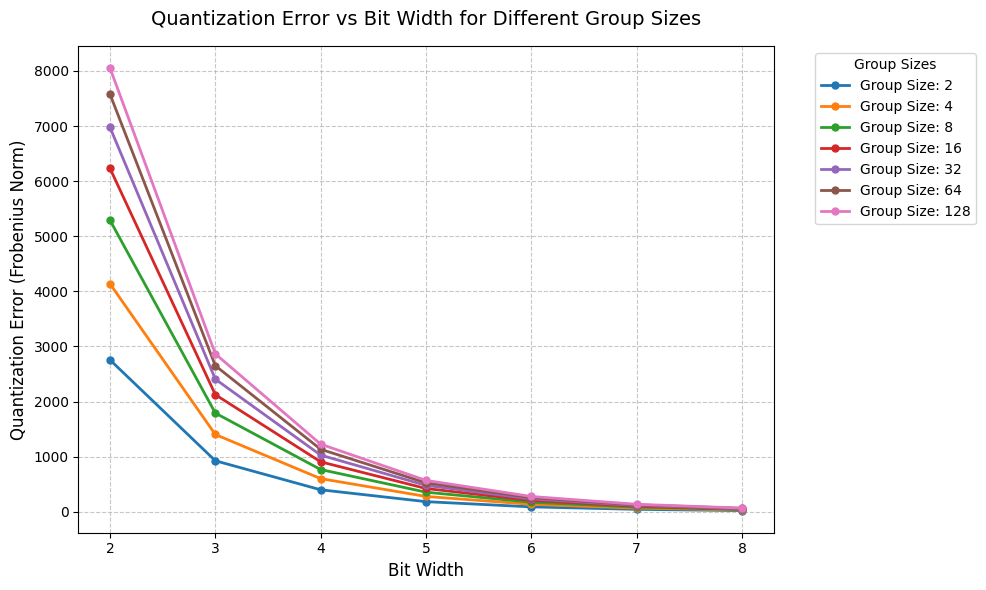

In [4]:
plt.figure(figsize=(10, 6))

for group_size in valid_group_sizes:
    errors = []
    for bitwidth in range(2, 9):
        s = compute_linear_scale(w, bitwidth=bitwidth, group_size=group_size)
        q_w = quantize_linear(w, s, bitwidth=bitwidth, group_size=group_size)
        d_w = dequantize_linear(q_w, s, group_size=group_size)
        error = torch.norm(w - d_w, p='fro').item()
        errors.append(error)

    plt.plot(range(2, 9), errors, '-o', linewidth=2, markersize=5, label=f'Group Size: {group_size}')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Bit Width', fontsize=12)
plt.ylabel('Quantization Error (Frobenius Norm)', fontsize=12)
plt.title('Quantization Error vs Bit Width for Different Group Sizes', fontsize=14, pad=15)
plt.xticks(range(2, 9))
plt.legend(title='Group Sizes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

> The plot demonstrates an exponential decrease in quantization error as the bit-width increases. Furthermore, smaller group sizes consistently achieve lower quantization error, as illustrated by the different curves. This validates our earlier intuition about group size's impact on quantization accuracy.

### 🧠 Applying Linear Asymmetric Quantization

We’ve now explored how linear asymmetric quantization works and how the group-size and bit-width affect quantization error. However now let’s apply it to your trained model and evaluate its impact on **task accuracy**, which ultimately matters most.

We'll do this by implementing a custom `nn.Module` that stores quantized weights, biases (if present), and quantization parameters (`scale`, `zero_point`) as non-trainable buffers of a nn.Linear layer. We will also implement the logic for a forward pass, that involves dequantizing the weights, with the equations we used and then performing the linear operations.

In [5]:
import torch.nn as nn 
import torch.nn.functional as F


def quant_activation(x, bitwidth=8):
    r_max = x.abs().max()
    scale = r_max / (2**(bitwidth-1) - 1)
    q_x = torch.clamp(torch.round(x / scale), -2**(bitwidth-1), 2**(bitwidth-1) - 1)
    return q_x.to(x.dtype), scale.to(x.dtype)

def dequant_activation(q_x, scale):
    return q_x * scale

class QLinear(nn.Module): 
    def __init__(self, in_features, out_features, bias=False, bitwidth=8, group_size=None): 
        super(QLinear, self).__init__()
        if group_size == None: 
            group_size = in_features
        assert in_features % group_size == 0 
        self.group_size = group_size
            
        self.in_features = in_features
        self.out_features = out_features
        self.bitwidth = bitwidth
    
        # Convert to desired dtype
        self.register_buffer('weight', torch.zeros(out_features, in_features, dtype=self.get_dtype(), requires_grad=False))
        if bias: 
            self.register_buffer('bias', torch.randn(out_features, dtype=torch.float32))
        else: 
            self.bias = None
        self.register_buffer('scale', torch.randn(out_features * (in_features // group_size), dtype=torch.float32))
        
    @classmethod
    def from_linear(cls, linear_layer: nn.Linear, bitwidth=8, group_size=None):
        has_bias = linear_layer.bias is not None
        qlinear = cls(linear_layer.in_features, linear_layer.out_features, has_bias, bitwidth, group_size=group_size)
        scale = compute_linear_scale(linear_layer.weight, bitwidth, group_size=group_size)
        qlinear.scale.data = scale
        if has_bias:
            qlinear.bias.data = linear_layer.bias.data
        qlinear.weight.data = quantize_linear(linear_layer.weight, scale, bitwidth=bitwidth, group_size=group_size)
        return qlinear

    def forward(self, x): 
        q_x, scale = quant_activation(x, 8)
        d_x = dequant_activation(q_x, scale)
        d_w = dequantize_linear(self.weight, self.scale, self.group_size)
        return F.linear(d_x, d_w, self.bias)

    def get_dtype(self): 
        return torch.float32

    def __repr__(self):
        return f"QLinear(in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}, bitwidth={self.bitwidth})"
    


### 🔁 Replacing Linear Layers with Quantized Versions

Now that we have our quantized version of the linear layer (QLinear) we can quantize the entire model. Next we define a recursive function to do this that replaces all `nn.Linear` layers of your vision transformer with `QLinear` modules.

The `skip_layers` argument allows us to exclude sensitive layers (e.g., the input projection and output head), which are often critical for maintaining accuracy.

In [6]:
def quantize_module(module, bitwidth=8, group_size=None, skip_layers=["model.linear"], parent_name=''):
    skip_layers = skip_layers or []
    
    for name, layer in module.named_children():
        full_name = f"{parent_name}.{name}" if parent_name else name
        
        # If this layer is in skip_layers, skip it and its children
        if full_name in skip_layers:
            continue
            
        if isinstance(layer, nn.Linear):
            setattr(module, name, QLinear.from_linear(layer, bitwidth=bitwidth, group_size=group_size))
        else:
            # Recursively handle nested modules, passing along the parent_name
            quantize_module(layer, bitwidth=bitwidth, group_size=group_size, skip_layers=skip_layers, parent_name=full_name)



### 📉 Evaluating Accuracy vs. Quantization

We now test how quantization affects model accuracy. By varying **bitwidths** from 2 to 9 and **group sizes** with ```valid_group_sizes```, we quantize the model and evaluate task accuracy.

This lets us plot accuracy degradation across configurations, helping us balance compression with performance.

Group Size: 128, Bitwidth: 8: 100%|██████████| 14/14 [01:18<00:00,  5.60s/it]


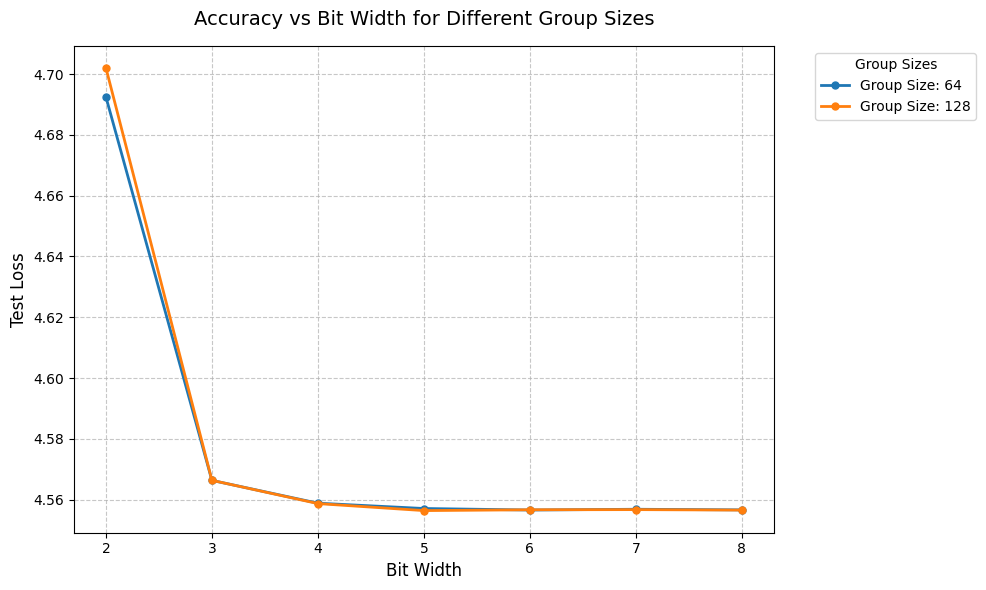

In [17]:
from src.lab1.shakespeare_trainer import ShakespeareModule
import pytorch_lightning as pl 
from tqdm import tqdm 
import contextlib
import os 
import matplotlib.pyplot as plt
import os 
import logging

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


trainer = pl.Trainer(
    max_epochs=1,                                     
    accelerator="auto",                                
    devices="auto",                                    
    precision=32,                             
    enable_progress_bar=False
)

valid_group_sizes = [64, 128] # None entry results in per-channel quantization

plt.figure(figsize=(10, 6))

total_steps = len(valid_group_sizes) * (9 - 2)  # Total number of iterations
pbar = tqdm(total=total_steps, desc="Overall Progress")

all_accuracies = []
for group_size in valid_group_sizes:
    accuracy = [] 
    for bitwidth in range(2, 9):
        module = ShakespeareModule.load_from_checkpoint("src/lab1/checkpoints/best.ckpt")
        quantize_module(module, bitwidth=bitwidth, group_size=group_size)
        #print(module)
        #with open(os.devnull, 'w') as devnull:
        #    with contextlib.redirect_stdout(devnull), contextlib.redirect_stderr(devnull):
        result = trainer.test(module, verbose=False)
        #print(result)
        accuracy.append(result[0]['test_loss'])
        pbar.set_description(f"Group Size: {group_size}, Bitwidth: {bitwidth}")
        pbar.update(1)
    plt.plot(range(2, 9), accuracy, '-o', linewidth=2, markersize=5, label=f'Group Size: {group_size}')
    all_accuracies.append(accuracy)


pbar.close()


plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Bit-Width', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.title('Accuracy vs Bit Width for Different Group Sizes', fontsize=14, pad=15)
plt.xticks(range(2, 9))
plt.legend(title='Group Sizes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


### 🧠 The Impact of Low-Bit Quantization on Neural Networks

Reducing the bit-width of weight quantization has a well-documented and detrimental effect on model accuracy, particularly when dropping below 4 bits. This degradation persists even when reducing the group size to increase the granularity of quantization, indicating that finer local adaptation alone is not sufficient to preserve performance. We saw this with the figures and interactive plots above.

Additionally we should also recognize that **weight quantization** is only part of the story. When **activation quantization** is also applied, the reduction in accuracy can become even more pronounced. However, these performance trade-offs come with substantial gains in computational efficiency, memory footprint, and energy consumption—making low-bit quantization a compelling approach for edge deployment and efficient inference.
 
One particularl form of extreme quantization is **ternary quantization**, where weights and/or activations are constrained to the set:
 
$\{-1, 0, 1\} $
 
This drastically simplifies the required computations: multiply-accumulate (MAC) operations reduce to a combination of sparse additions and subtractions. Since zero-valued weights require no computation, this naturally induces sparsity and leads to **reduced memory bandwidth** and **lower power usage**. These savings are especially important on devices with limited compute and energy budgets, such as microcontrollers or mobile accelerators.

For example, consider computing a dot product between input **$x=[x_1,x_2,x_3,x_4]$** and ternary weights **$w=[1,0,-1,1]$**:
# 
Traditional MAC: **$ y = x_1 * 1 + x_2 * 0 + x_3 * (-1) + x_4 * 1$** <br>
Simplified:      **$ y = x_1 - x_3 + x_4$**  

The zero weight eliminates one operation entirely, while the +1/-1 weights turn multiplications into simple additions or subtractions. This makes the computation much more efficient compared to full-precision multiply-accumulates.


---

### ⚙️ Implementing Ternary Quantization

Let’s begin by implementing **ternary quantization**, where a full-precision weight matrix $W \in \mathbb{R}^{k \times n}$ is mapped to a matrix $\hat{W} \in \{-1, 0, 1\}^{k \times n}$. 

A common method for this is the **absmean thresholding** strategy, applied per tensor. The idea is simple: compute a threshold $( \Delta )$ from the mean absolute value of the tensor, and apply it to produce the ternary quantized weights.

Given a full-precision weight tensor $ W $, the ternarization is defined as:

$
\Delta = \alpha \cdot \frac{1}{|W|} \sum_{i,j} |W_{i,j}|
$

where $\Delta$ is the threshold and $|W|$ is the number of elements in $W$. The scale parameter $ \alpha $ is a scaling factor, typically set to $ \alpha = 0.7 $–$ 0.9 $ [depending on empirical tuning](https://arxiv.org/abs/1605.04711). To complete the ternary quantization, we apply this threshold to produce the ternary weight matrix $|w|$ with the following formula:

$
\hat{W}_{i,j} = 
\begin{cases}
+1 & \text{if } W_{i,j} > \Delta \\
-1 & \text{if } W_{i,j} < -\Delta \\
0  & \text{otherwise}
\end{cases}
$

This simple heuristic works surprisingly well for many network layers including convolutions and linear layers. The dequantization is as follows:

$
\hat{W}_{\text{scaled}} = \Delta     \cdot \hat{W}
$



> 🔧 In the next cell, we’ll implement this method in PyTorch and apply it to a sample weight matrix.



In [8]:
import torch
import matplotlib.pyplot as plt

def ternary_quant_weight(w: torch.Tensor, alpha: float = 0.7):
    delta = w.abs().mean() * alpha
    w_q = torch.zeros_like(w)
    w_q.masked_fill_(w >  delta,  1.0)
    w_q.masked_fill_(w < -delta, -1.0)
    return w_q, delta

# Generate original weight matrix
w = torch.randn(128, 128)

# Apply quantization
q_w, delta = ternary_quant_weight(w)
d_w = delta * q_w  # Dequantized version

# Plot distribution of original weights
plt.figure(figsize=(10, 5))
plt.hist(w.flatten().cpu().numpy(), bins=100, color='skyblue', alpha=0.8, label='Original Weight Distribution')

# Plot ternary centroids
for val, label in [(-delta.item(), '-Δ'), (0.0, '0'), (delta.item(), '+Δ')]:
    plt.axvline(val, color='red', linestyle='--', linewidth=2, label=label)

plt.title("Original Weight Distribution with Ternary Centroids")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

On the graph above, you can see the original weight distribution and the ternary quantization levels. The dotted red lines are the thresholds for ternary quantization.

### 🧪 Training with Non-Differentiable Quantization Functions

You can see in the graph above that the original weight distribution is mapped to the nearest ternary quantization level (dotted red lines). This drastically reduces the number of bits needed per weight as only three levels are used, resulting in major memory and compute savings. Theoretically, theoretically ternary quantization only requires only 1.58 bits per weight, as $log_2(3) = 1.58$ and there are only three possible states: -Δ, 0, and +Δ.

❗ However, this quantization comes at a significant memory cost: **information loss**. Such coarse quantization degrades model performance unless the network is trained to be robust to it.

---

### ❓ The Key Question

> **How can we aggressively reduce bit-width to 1.58 bits per weight while preserving accuracy?**

The answer: **Quantization-Aware Training (QAT)**—a technique that simulates quantization during training so the model can adapt to it.

---

### 🚫 The Gradient Problem

QAT is non-trivial because **quantization is non-differentiable**.

Take the ternary quantization function:

$
\hat{W}_{i,j} = Q^T(W_{i,j}) = 
\begin{cases}
+1 & \text{if } W_{i,j} > \Delta \\
-1 & \text{if } W_{i,j} < -\Delta \\
0  & \text{otherwise}
\end{cases}
$

As shown by the figure below, the function is piecewise constant, with a derivative of:

### $\frac{d\hat{W}}{dW} = 0 \quad \text{(almost everywhere)}, \quad \text{undefined at } \Delta, 0 \text{and} -\Delta$

As shown in the plots below, the quantization function is a step map (left), and its derivative is zero or undefined (right). This breaks Backpropagation: 
<br>
<br>
$
W_{t+1} = W_t - \eta \cdot \frac{\partial \mathcal{L}}{\partial W} \\
\quad\quad\text{ } =  W_t - \eta \cdot \frac{\partial \mathcal{L}}{\partial \hat{W}} \cdot \frac{d\hat{W}}{dW} \\
\quad \text{but } \frac{\partial \mathcal{\hat{W}}}{\partial W} \text{is undefined}
$

---

### 🛠️ Straight-Through Estimator (STE)

To work around this, we use **approximate gradients** like the **Straight-Through Estimator (STE)**:

$
\frac{d\hat{\hat{W}}}{dW} \approx 1
$

STE bypasses the quantization op in the backward pass, letting gradients flow through as if quantization were the identity. While crude, it works remarkably well in practice.

<center><img src="./assets/lab1/gradient_and_ste_gradient.png" width="900"/></center>

---

### 🧰 Putting It All Together: QAT in Practice

We start with a full-precision model, e.g.,  as a very simple example take a linear layer (without bias):

$
y = W x
$

During Ternary QAT, we **simulate quantization during the forward pass**:

$
\hat{y} = Q^T(W) \cdot x
$

But during the backward pass, we apply STE on the quantization function $Q^T$ and backpropagate to the weights as if they were never quantized:

$
\frac{\partial \mathcal{L}}{\partial W} \approx \frac{\partial \mathcal{L}}{\partial Q(W)}
$

Then once, training is complete, we can drop the full precision weights $W$ are replace them with the quantized weights $\hat{W}$ = Q^T(W) and use the quantized weights for inference.

---

### 🧠 Outcome

The outcome of QAT is a model that **learns to be robust to quantization**, maintaining strong accuracy even at low bit-widths (4-bit, ternary, binary).

> 🔜 So now let's give it a go with the ternary example. Using just 1.58 bits per weight!   

To implement it now define a custom **autograd function** to apply ternary quantization to weights during the forward pass, while using the **Straight-Through Estimator (STE)** in the backward pass.

This lets us propagate gradients through non-differentiable ternary quantization operations, enabling training with standard pytorch optimizers.


In [9]:
from torch.autograd import Function 

class TernaryWeightQuant(Function):
    @staticmethod
    def forward(ctx, w):
        q_w, delta = ternary_quant_weight(w)
        ctx.save_for_backward(w)
        ctx.delta = delta
        return q_w * delta

    @staticmethod
    def backward(ctx, grad_output):
        w, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # Gradient approximation: pass through only gradients of elements within clipping bounds
        grad_input[w.abs() > 1] = 0
        return grad_input


def ternary_weight_quant_ste(w): 
    return TernaryWeightQuant.apply(w)

def quant_activation(x, bitwidth=8):
    r_max = x.abs().max()
    scale = r_max / (2**(bitwidth-1) - 1)
    q_x = torch.clamp(torch.round(x / scale), -2**(bitwidth-1), 2**(bitwidth-1) - 1)
    return q_x, scale


class IntActivationQuant(Function):
    @staticmethod
    def forward(ctx, w):
        q_x, scale = quant_activation(w)
        ctx.save_for_backward(w, scale)
        return q_x * scale 

    @staticmethod
    def backward(ctx, grad_output):
        w, scale = ctx.saved_tensors
        grad_input = grad_output.clone()
        # Pass gradients only where activations were not saturated
        grad_input[(w / scale).abs() >= (2**7 - 1)] = 0
        return grad_input
    
def int_activation_quant(w): 
    return IntActivationQuant.apply(w)

### 🧱 Integrating Ternary Quantization into a Linear Layer

Next, we wrap this ternary quantization function inside a custom `TernaryLinear` layer. This layer behaves like a standard `nn.Linear`, but quantizes its weights to the ternary set {−1, 0, 1} during the forward pass.

This makes it easy to plug into any PyTorch model and observe the effect of ternary quantization on downstream accuracy.


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TernaryLinear(nn.Linear):
    def forward(self, x):
        d_x = int_activation_quant(x)
        d_w = ternary_weight_quant_ste(self.weight)
        return F.linear(d_x, d_w.to(x.device), self.bias)

    @classmethod
    def from_linear(cls, linear_layer: nn.Linear): 
        device = linear_layer.weight.device
        has_bias = linear_layer.bias is not None
        tlinear = cls(linear_layer.in_features, linear_layer.out_features, has_bias)
        tlinear.weight.data = linear_layer.weight.data
        if has_bias: 
            tlinear.bias.data = linear_layer.bias.data
        return tlinear.to(device)
        
    def __repr__(self): 
        return f"TLinear(in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None})"


### 🔄 Recursively Replacing Layers with TernaryLinear

This function searches through the model and replaces all `nn.Linear` layers—except those specified in `skip_layers`—with their ternary quantized equivalents.

We pass the `parent_name` to preserve full layer paths, ensuring correct matching for selective replacement.


In [11]:
def quantize_module_ternary(module, skip_layers=["model.mlp_head", "model.to_patch_embedding.2"], parent_name=''):
    skip_layers = skip_layers or []
    
    for name, layer in module.named_children():
        full_name = f"{parent_name}.{name}" if parent_name else name
        
        # If this layer is in skip_layers, skip it and its children
        if full_name in skip_layers:
            continue
        
        if isinstance(layer, nn.Linear):
            setattr(module, name, TernaryLinear.from_linear(layer))
        else:
            # Recursively handle nested modules, passing along the parent_name
            quantize_module_ternary(layer, skip_layers=skip_layers, parent_name=full_name)

### 🔍 Verifying Ternary Layer Replacement

Let’s load a pretrained model and apply ternary quantization to its internal linear layers. After replacement, we print the model to confirm that all expected layers have been converted.


In [12]:
module = ShakespeareModule.load_from_checkpoint("src/lab1/checkpoints/best.ckpt")
quantize_module_ternary(module)
print(module)


ShakespeareModule(
  (model): AutoRegressiveTransformer(
    (embedding): Embedding(1024, 256)
    (pos_encoder): Embedding(1024, 256)
    (transformer_blocks): ModuleList(
      (0-7): 8 x TransformerBlock(
        (self_attn): MultiHeadAttention(
          (qkv_proj): TLinear(in_features=256, out_features=768, bias=True)
          (out_proj): TLinear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): FeedForward(
          (linear1): TLinear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): TLinear(in_features=1024, out_features=256, bias=True)
          (activation): GELU(approximate='none')
        )
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=Fals

### 🚀 Time to Train!

With ternary quantization applied, we’re ready to fine-tune the model using quantization-aware training. Let’s see how well the model performs under aggressive compression!


In [13]:
from pytorch_lightning.callbacks import ModelCheckpoint
from src.lab1.shakespeare_trainer import PlotlyCallback

checkpoint_callback = ModelCheckpoint(
    monitor='val_perplexity',                                 # the metric to monitor 
    mode='max',                                        # the mode to use for the monitor
    save_top_k=1,                                      # the number of top models to save
    save_last=True,                                    # whether to save the last model
    dirpath='./src/lab1/checkpoints',                 # the path to save the model during training
    filename='ternary-best'                                    # save the best model as 'best.ckpt'
)


trainer = pl.Trainer(
    max_epochs=1,                                      # the number of epochs to train fo
    callbacks=[PlotlyCallback(val_check_interval=0.1), checkpoint_callback],  # the callbacks to use during training
    accelerator="auto",                                 # the accelerator to use during training
    devices="auto",                                     # the devices to use during training
    precision="16-mixed",                                        # the precision to use during training
    val_check_interval=0.1,    
)
trainer.fit(module)

In [18]:
module = ShakespeareModule.load_from_checkpoint("src/lab1/checkpoints/ternary-best-v1.ckpt")
quantize_module_ternary(module)
module.eval()
result = trainer.test(module)

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           4.6009931564331055
     test_perplexity        101.52334594726562
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


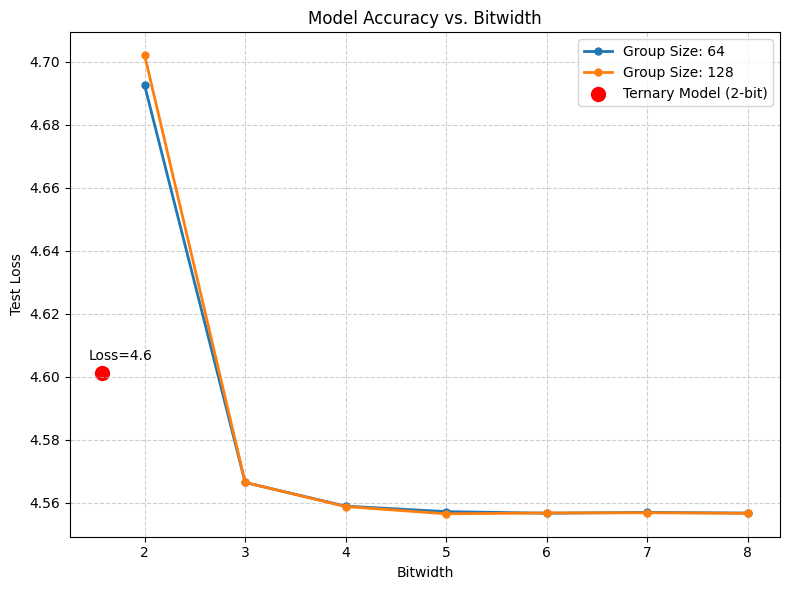

In [32]:
import matplotlib.pyplot as plt

# Assume accuracy is in percentage already, if not: [a * 100 for a in accuracy]
plt.figure(figsize=(8, 6))

# Plot the accuracy vs. bitwidth
for idx, group_size in enumerate(valid_group_sizes): 
    plt.plot(range(2, 9), all_accuracies[idx], '-o', linewidth=2, markersize=5, label=f'Group Size: {group_size}')
#plt.plot(accuracy, marker='o', linestyle='-', label='Model Accuracy')

# Highlight the ternary (2-bit) model
ternary_bit = 1.58
ternary_acc = result[0]['test_loss'] 
plt.scatter([ternary_bit], [ternary_acc], color='red', s=100, label='Ternary Model (2-bit)')
plt.annotate(f'Loss={ternary_acc:.1f}', (ternary_bit, ternary_acc), textcoords="offset points", xytext=(-10,10), ha='left')

# Labels and title
plt.xlabel('Bitwidth')
plt.ylabel('Test Loss')
plt.title('Model Accuracy vs. Bitwidth')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


You can see from this graph that the ternary model, with only 1.58 bits per weight achieview significantly higher accuracy that the standard 2-bit post-training quantized model.

### ⚫ Binary Quantization: Compressing Weights to Just 1 Bit

Binary quantization takes compression to its extreme. Here, each weight is constrained to one of two values:

$\hat{W}_{i,j} \in \{-1, +1\}$

This allows **each weight to be represented with just 1 bit**, yielding up to **32× compression** compared to 32-bit floating point. Moreover, in hardware, binary weights unlock **highly efficient bitwise operations**, such as **XNOR + popcount**, instead of costly multiply-accumulate (MAC) operations.

> Binary networks are thus not only ultra-compact but also tailored for **fast, energy-efficient inference on digital hardware**.

---

### 🧮 How Do We Compute Binary Weights?

A common method is to apply the **sign function**:

$$
\hat{W} = \text{sign}(W) =
\begin{cases}
+1 & \text{if } W \ge 0 \\
-1 & \text{otherwise}
\end{cases}
$$

However, this introduces a **serious issue**: **magnitude information is lost**. Every weight has the same absolute value, which limits the model’s expressive power. To mitigate this, we introduce a **scaling factor**:

$$
\hat{W}_{\text{scaled}} = \alpha \cdot \text{sign}(W)
$$

Where $\alpha$ is typically computed as the mean absolute value of weights in a group:

$$
\alpha = \frac{1}{|W|} \sum_{i,j} |W_{i,j}|
$$

This scaled version of binarization preserves a coarse notion of magnitude and improves performance without increasing the number of bits.



In [54]:
def binary_quant_forward(w: torch.Tensor): 
    alpha = w.abs().mean()
    return torch.sign(w), alpha

w = torch.randn(10)
w_q, alpha = binary_quant_forward(w)
print("Binary Weight: ",w_q)
print("Scale: ", alpha)

Binary Weight:  tensor([-1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1., -1.])
Scale:  tensor(0.6929)


### 🚫 The Gradient Problem

As we have seen with previous quantization proceedures, it is a **non-differentiable** process, which breaks backpropagation. The derivative of the sign function is zero almost everywhere:

$$
\frac{d}{dW} \text{sign}(W) = 0 \quad \text{(almost everywhere)}
$$

This leads to vanishing gradients:

$$
\frac{\partial \mathcal{L}}{\partial W} = \frac{\partial \mathcal{L}}{\partial \hat{W}} \cdot \frac{d \hat{W}}{dW} = 0
$$

To circumvent this, we can use the **Straight-Through Estimator (STE)**. It approximates the derivative of the quantization function during backpropagation:

$$
\frac{d \hat{W}}{dW} \approx 1
$$

This approximation allows gradients to flow through the quantization operation, enabling end-to-end training.

---

### 🧠 Binary Quantization in Practice

During training, we simulate binary quantization using the `sign` function and apply a learned or computed scaling factor:

$$
\hat{W} = \alpha \cdot \text{sign}(W)
$$

The **forward pass** uses this binarized version of the weights, while the **backward pass** uses STE to propagate gradients through the full-precision weights.

At **inference**, we discard the full-precision weights and retain only `sign(W)` and the scaling factor $\alpha$




In [59]:
import torch
from torch.autograd import Function

class BinaryQuantFunction(Function):
    @staticmethod
    def forward(ctx, w):
        q_w, alpha = binary_quant_forward(w)  # assumes your custom logic here
        return q_w * alpha

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output, None  # STE: pass-through gradient

def binary_quant(w):
    return BinaryQuantFunction.apply(w)

w = torch.randn(128, 128, requires_grad=True)
w_q = binary_quant(w)


---

### 🧪 Quantization-Aware Training (QAT)

To retain accuracy with binary weights, we should use **Quantization-Aware Training (QAT)** to train the model to be robust to these constraints. This approach simulates quantization during training so that the model can adapt to low-precision constraints.

For binary quantization, since the constraint is so significant, we should use group-wise quantization, where weights are quantized with a single scale per group::

$$
\hat{W}_{i,j} = \alpha_g \cdot \text{sign}(W_{i,j})
$$

Here, $\alpha_g$ is the mean absolute value of the weights in group $g$ (e.g., 64 or 128 elements).

During backpropagation, we again apply the **Straight-Through Estimator** wihtout any alterations:

$$
\frac{\partial \mathcal{L}}{\partial W} \approx \frac{\partial \mathcal{L}}{\partial \hat{W}}
$$

You can see this implemented below.


In [63]:
class GroupBinaryQuantFunction(Function):
    @staticmethod
    def forward(ctx, w, group_size=128):
        w_reshaped = w.reshape(-1, group_size)
        alpha = w_reshaped.abs().mean(dim=1, keepdim=True)
        q_w = w_reshaped.sign() * alpha
        return q_w.reshape(w.shape)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output, None  # STE

def group_binary_quant(w, group_size=128):
    return GroupBinaryQuantFunction.apply(w, group_size)

w = torch.randn(128, 128, requires_grad=True)
w_q = group_binary_quant(w, group_size=32)


> Lets now integrate this group-wise binary quantization function into a custom `BinaryLinear` layer.

### 🧱 BinaryLinear Layer

We define a custom layer that wraps the binary quantization logic inside the forward pass of a standard linear layer. During training, weights are quantized before use. During inference, we discard the full-precision weights entirely and use only the binary version.

---

In [64]:
import torch.nn as nn
import torch.nn.functional as F

class BinaryLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, group_size=32):
        super().__init__(in_features, out_features, bias)
        self.group_size = group_size
        
    def forward(self, x):
        w_q = group_binary_quant(self.weight, self.group_size)
        return F.linear(x, w_q.to(x.device), self.bias)

    @classmethod
    def from_linear(cls, linear_layer: nn.Linear, group_size=32):
        has_bias = linear_layer.bias is not None
        binary = cls(linear_layer.in_features, linear_layer.out_features, bias=has_bias, group_size=group_size)
        binary.weight.data = linear_layer.weight.data.clone()
        if has_bias:
            binary.bias.data = linear_layer.bias.data.clone()
        return binary.to(linear_layer.weight.device)

    def __repr__(self):
        return f"BLinear(in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}, group_size={self.group_size})"



### 🔄 Recursively Replacing Layers

To apply binary quantization across a model, we replace each `nn.Linear` layer with our custom `BinaryLinear` version. This can be done recursively, skipping any layers we want to preserve (e.g., output heads).

---

In [65]:
def quantize_module_binary(module, skip_layers=[], parent_name='', group_size=32):
    for name, child in module.named_children():
        full_name = f"{parent_name}.{name}" if parent_name else name

        if full_name in skip_layers:
            continue

        if isinstance(child, nn.Linear):
            setattr(module, name, BinaryLinear.from_linear(child, group_size=group_size))
        else:
            quantize_module_binary(child, skip_layers, full_name, group_size=group_size)


### 🚀 Training with Binary Quantization

Once the binary layers are in place, we fine-tune the network using Quantization-Aware Training. During training, quantization is simulated at each forward pass, and STE allows gradients to flow.

As with ternary networks, this teaches the model to become robust to the distortions introduced by extreme quantization.

---

In [66]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

# Load pretrained model and quantize
model = ShakespeareModule.load_from_checkpoint("src/lab1/checkpoints/best.ckpt")
quantize_module_binary(model)

# Fine-tune using binary weights
checkpoint_callback = ModelCheckpoint(
    monitor='val_perplexity',
    mode='min',
    save_top_k=1,
    save_last=True,
    dirpath='./src/lab1/checkpoints',
    filename='binary-best'
)

trainer = Trainer(
    max_epochs=1,
    callbacks=[PlotlyCallback(val_check_interval=0.1), checkpoint_callback],
    accelerator="auto",
    devices="auto",
    precision="16-mixed",
    val_check_interval=0.1
)

trainer.fit(model)


### 🧪 Testing and Visualization

After training, we evaluate the quantized model on the test set and compare performance to models quantized at higher bit-widths (e.g., 2-bit, 4-bit).

We can visualize the trade-off between **bitwidth** and **model loss/accuracy**, highlighting how the binary model (1-bit) performs relative to the ternary (1.58-bit) and standard quantized models.

---

In [67]:
model = ShakespeareModule.load_from_checkpoint("src/lab1/checkpoints/binary-best.ckpt")
quantize_module_binary(model)
model.eval()
result = trainer.test(model)

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            4.66631555557251
     test_perplexity         110.4622573852539
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### 🧠 Outcome

With **just 1-bit per weight**, the model is able to maintain **surprisingly competitive performance**, especially when fine-tuned using QAT. While binary quantization removes all magnitude information, with STE-based training the model can adapt to this harsh constraint.

This represents one of the most memory- and energy-efficient forms of quantization available today, particularly suited for **edge devices, microcontrollers, and custom ASICs**.

> Next up, try combining binary **weights** with **quantized activations** for full integer inference!


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a924536c7c0>
Traceback (most recent call last):
  File "/home/oliver/miniconda3/envs/qplacefinder_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/home/oliver/miniconda3/envs/qplacefinder_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/oliver/miniconda3/envs/qplacefinder_env/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/oliver/miniconda3/envs/qplacefinder_env/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/oliver/miniconda3/envs/qplacefinder_env/lib/python3.12/multiprocessing/connection.py", line 1118, in wa

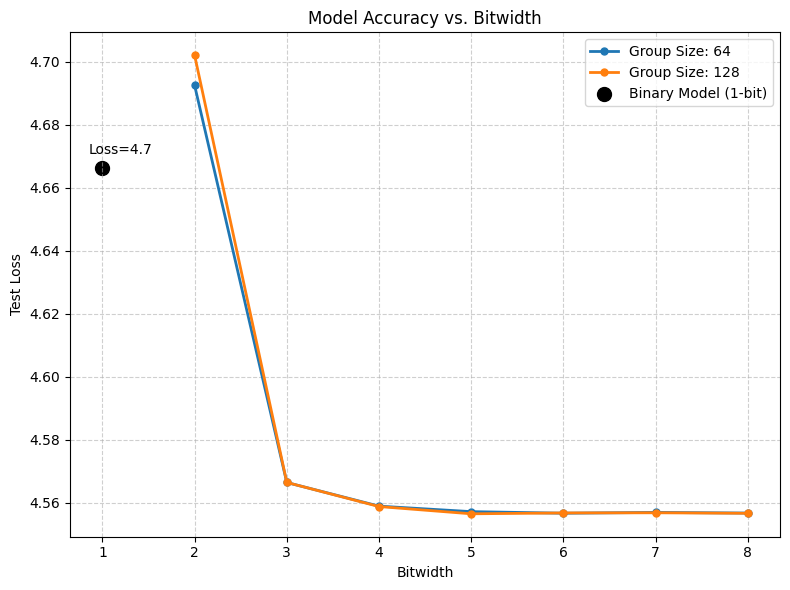

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for idx, group_size in enumerate(valid_group_sizes): 
    plt.plot(range(2, 9), all_accuracies[idx], '-o', linewidth=2, markersize=5, label=f'Group Size: {group_size}')

# Highlight binary model
binary_bit = 1.0
binary_loss = result[0]['test_loss']
plt.scatter([binary_bit], [binary_loss], color='black', s=100, label='Binary Model (1-bit)')
plt.annotate(f'Loss={binary_loss:.1f}', (binary_bit, binary_loss), textcoords="offset points", xytext=(-10,10), ha='left')

plt.xlabel('Bitwidth')
plt.ylabel('Test Loss')
plt.title('Model Accuracy vs. Bitwidth')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Use nicer plot styling
plt.style.use("seaborn-v0_8-whitegrid")

# Parameters
delta = 0.5
x = np.linspace(-1.5, 1.5, 1000)

# Quantization function Q^T(x)
def quantize_ternary(x, delta):
    return np.where(x > delta, 1, np.where(x < -delta, -1, 0))

# STE approximation function (e.g., hardtanh)
def ste_function(x, delta):
    return np.clip(x, -1, 1)

# True gradient (0 everywhere, "infinite" at thresholds)
def true_gradient(x, delta):
    return np.zeros_like(x)

# STE gradient (identity in [-delta, delta])
def ste_gradient(x, delta):
    return np.where(np.abs(x) <= delta, 1, 0)

# Compute values
q_vals = quantize_ternary(x, delta)
ste_vals = ste_function(x, delta)
true_grad_vals = true_gradient(x, delta)
ste_grad_vals = ste_gradient(x, delta)

# Create figure
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# --- LEFT PLOT: Function and STE ---
axs[0].plot(x, q_vals, label=r'Quantization $Q^T(w)$', color='black', linewidth=2)
axs[0].plot(x, ste_vals, label='STE Function', linestyle='--', color='royalblue', linewidth=2)
axs[0].axvline(delta, color='gray', linestyle=':', linewidth=1)
axs[0].axvline(-delta, color='gray', linestyle=':', linewidth=1)
axs[0].set_title('Quantization Function and STE', fontsize=16)
axs[0].set_xlabel('$w$', fontsize=14)
axs[0].set_ylabel('$Q^T(w)$ or STE', fontsize=14)
axs[0].legend(fontsize=13)
axs[0].set_ylim([-1.2, 1.2])

# --- RIGHT PLOT: Gradients ---
axs[1].plot(x, true_grad_vals, label='True Gradient', color='black', linewidth=2)
axs[1].plot(x, ste_grad_vals, label='STE Gradient', linestyle='--', color='firebrick', linewidth=2)
axs[1].set_ylim([-0.1, 1.2])

# Add "infinite" gradients as vertical arrows
for loc in [-delta, delta]:
    axs[1].annotate('', xy=(loc, 1.0), xytext=(loc, 0.05),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8),
                    annotation_clip=False)
    #axs[1].text(loc + 0.02, 1.05, r'$\delta(x \pm \Delta)$', fontsize=12, rotation=0)

axs[1].axvline(delta, color='gray', linestyle=':', linewidth=1)
axs[1].axvline(-delta, color='gray', linestyle=':', linewidth=1)
axs[1].set_title('Gradient and STE Gradient', fontsize=16)
axs[1].set_xlabel('w', fontsize=16)
axs[1].set_ylabel('Gradient', fontsize=16)
axs[1].legend(fontsize=14)

plt.tight_layout()
plt.show()

fig.savefig('assets/lab1/gradient_and_ste_gradient.png')

In [ ]:
print("Hi")